# Linear And Cyclical Workflows Using Functions And States

Using the functions in `autora.state`, we can build flexible pipelines and cycles which operate on state objects.

The fundamental idea is this:
- We define a "state" object $S$ which can be modified with a "delta" (a new result) $\Delta S$.
- A new state at some point $i+1$ is $$S_{i+1} = S_i + \Delta S_{i+1}$$
- The cycle state after $n$ steps is thus $$S_n = S_{0} +  \sum^{n}_{i=1} \Delta S_{i}$$

To represent $S$ and $\Delta S$ in code, you can use `autora.state.delta.State` and `autora.state.delta.Delta`
respectively. To operate on these, we define functions.

- Each operation in an AER cycle (theorist, experimentalist, experiment_runner, etc.) is implemented as a
function with $n$ arguments $s_j$ which are members of $S$ and $m$ others $a_k$ which are not.
  $$ f(s_0, ..., s_n, a_0, ..., a_m) \rightarrow \Delta S_{i+1}$$
- There is a wrapper function $h$ (`autora.state.delta.wrap_to_use_state`) which changes the signature of $f$ to
require $S$ and aggregates the resulting $\Delta S_{i+1}$
  $$h\left[f(s_0, ..., s_n, a_0, ..., a_m) \rightarrow \Delta
S_{i+1}\right] \rightarrow \left[ f^\prime(S_i, a_0, ..., a_m) \rightarrow S_{i} + \Delta
S_{i+1} = S_{i+1}\right]$$

- Assuming that the other arguments $a_k$ are provided by partial evaluation of the $f^\prime$, the full AER cycle can
then be represented as:
  $$S_n = f_n^\prime(...f_2^\prime(f_1^\prime(S_0)))$$

There are additional helper functions to wrap common experimentalists, experiment runners and theorists so that we
can define a full AER cycle using python notation as follows:

First initialize the State. There are two variables `x` with a range [-10, 10] and `y` with an unspecified range.

In [ ]:
from autora.state.bundled import StandardState
from autora.variable import VariableCollection, Variable

s_0 = StandardState(
    variables=VariableCollection(
        independent_variables=[Variable("x", value_range=(-10, 10))],
        dependent_variables=[Variable("y")]
    )
)

Specify the experimentalist. Use a standard function `random_pool_executor`.
This gets 5 independent random samples (by default, configurable using an argument)
from the value_range of the independent variables, and returns them in a DataFrame.

In [ ]:
from autora.experimentalist.pooler.random_pooler import random_pool_executor
experimentalist = random_pool_executor

Specify the experiment runner. This calculates a linear function, adds noise, assigns the value to the `y` column
 in a new DataFrame.

In [ ]:
import numpy as np
import pandas as pd
from autora.state.delta import Delta, wrap_to_use_state

rng = np.random.default_rng(180)

@wrap_to_use_state
def experiment_runner(conditions: pd.DataFrame, c=[2, 4]):
    x = conditions["x"]
    noise = rng.normal(0, 1, len(x))
    y = c[0] + (c[1] * x) + noise
    experiment_data = conditions.assign(y = y)
    return Delta(experiment_data=experiment_data)

Specify a theorist, using a standard LinearRegression from scikit-learn.

In [ ]:
from sklearn.linear_model import LinearRegression
from autora.state.wrapper import theorist_from_estimator

theorist = theorist_from_estimator(LinearRegression(fit_intercept=True))

Define the cycle: run the experimentalist, experiment_runner and theorist ten times.

In [ ]:
s_ = s_0
for i in range(10):
    s_ = experimentalist(s_)
    s_ = experiment_runner(s_)
    s_ = theorist(s_)

The experiment_data has 50 entries (10 cycles and 5 samples per cycle):

In [ ]:
s_.experiment_data

The fitted coefficients are close to the original intercept = 2, gradient = 4

In [ ]:
print(s_.model.intercept_, s_.model.coef_)

[2.07479102] [[4.01094241]]


In [ ]:
from typing import Optional
from dataclasses import field, dataclass

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.state.delta import State, Delta, wrap_to_use_state


## Experiment Runner And Theorist

We define a two part AER pipeline consisting of an experiment runner and a theorist (we use the seed conditions
always).

The key part here is that both experiment runner and theorist are functions which:
- operate on the `State`, and
- return a modified object of the **same type** `State`.

### Defining The State

We define the state as a dataclass, subclassed from `autora.state.delta.State` with fields representing the variables,
parameters, experimental data, (possibly) conditions, and (possibly) a model.

This state has no "history"; it represents a snapshot of the data at one time. Other exemplar state objects are
available in the subpackage `autora.state` and include some with in-built histories.

In [ ]:
@dataclass(frozen=True)
class Snapshot(State):
    variables: VariableCollection = field(metadata={"delta": "replace"})
    experiment_data: pd.DataFrame = field(default_factory=pd.DataFrame, metadata={"delta": "extend"})
    conditions: pd.Series = field(default_factory=pd.Series, metadata={"delta": "replace"})
    model: Optional[BaseEstimator] = field(default=None, metadata={"delta": "replace"})

s = Snapshot(
    variables=VariableCollection(independent_variables=[Variable("x", value_range=(-15,15))],
                                 dependent_variables=[Variable("y")]),
    conditions=pd.DataFrame({"x": np.linspace(-15,15,101)}),
    experiment_data = pd.DataFrame(columns=["x","y"]),
)

In [ ]:
s

Snapshot(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), experiment_data=Empty DataFrame
Columns: [x, y]
Index: [], conditions=        x
0   -15.0
1   -14.7
2   -14.4
3   -14.1
4   -13.8
..    ...
96   13.8
97   14.1
98   14.4
99   14.7
100  15.0

[101 rows x 1 columns], model=None)

### Defining The Experiment Runner

For this example, we'll use a polynomial of degree 3 as our "ground truth" function. We're also using pandas
DataFrames and Series as our data interchange format.

In [ ]:
coefs = [432, -144, -3, 1] # from https://www.maa.org/sites/default/files/0025570x28304.di021116.02p0130a.pdf

def ground_truth(x: pd.Series) -> pd.Series:
    y = pd.Series(coefs[0] + coefs[1] * x + coefs[2] * x**2 + coefs[3] * x**3, name="y")
    return y

def noisy_observation(x: pd.Series, std=1000, rng=None) -> pd.Series:
    if rng is None:
        rng = np.random.default_rng()
    y = ground_truth(x) + rng.normal(0, std, len(x))
    return y

def noisy_observation_df(df: pd.DataFrame, std=100, rng=None) -> pd.DataFrame:
    y = pd.DataFrame({"y": noisy_observation(df["x"], std=std, rng=rng)})
    return y

Given this state, we define a two part AER pipeline consisting of an experiment runner and a theorist. We'll just
reuse the initial seed `conditions` in this example.

First we define and test the experiment runner.

The key part here is that both the experiment runner and the theorist are functions which operate on the `State`. Therefore, we use a wrapper function `experiment_runner_from_x_to_y_function` that wraps the previously defined `noisy_observation_df` function and returns a function with the same functionality, but operating on the `State`. In this case, we want to use the `State` field `conditions` as input and extend the `State` field `experiment_data`.

In [ ]:
experiment_runner = experiment_runner_from_x_to_y_function(noisy_observation_df)

When we run the experiment runner, we can see the updated state object which is returned – it has new experimental data.

In [ ]:
experiment_runner(s, std=1).experiment_data

,x,y
0,-15.0,-1456.979354
1,-14.7,-1275.903805
2,-14.4,-1101.590466
3,-14.1,-936.923388
4,-13.8,-780.252340
...,...,...
96,13.8,502.578979
97,14.1,609.939995
98,14.4,723.255149
99,14.7,843.905227


### Defining The Theorist

Now we define a theorist, which does a linear regression on the polynomial of degree 5. We define a regressor and a
method to return its feature names and coefficients, and then the theorist to handle it. Here, we use a different wrapper `theorist_from_estimator` that wraps the regressor and returns a function with the same functionality, but operating on `State` fields. In this case, we want to use the `State` field `experiment_data` and extend the `State` field `models`.

In [ ]:
# Completely standard scikit-learn pipeline regressor
regressor = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
theorist = theorist_from_estimator(regressor)

def get_equation(r):
    t = r.named_steps['polynomialfeatures'].get_feature_names_out()
    c = r.named_steps['linearregression'].coef_
    return pd.DataFrame({"t": t, "coefficient": c.reshape(t.shape)})


### Directly Chaining State Based Functions

Now we run the theorist on the result of the experiment_runner (by chaining the two functions).

In [ ]:
t = theorist(experiment_runner(s, rng=np.random.default_rng(1)))

The fitted coefficients are:

In [ ]:
get_equation(t.model)

,t,coefficient
0,1,0.000000
1,x,-145.723526
2,x^2,-2.909293
3,x^3,1.048788
4,x^4,-0.000242
5,x^5,-0.000252


### Creating A Pipeline With State Based Functions

Now we can define the simplest pipeline which runs the experiment runner and theorist in sequence and returns the
updated state:

In [ ]:
def pipeline(state: State, rng=None) -> State:
    s_ = state
    t_ = experiment_runner(s_, rng=rng)
    u_ = theorist(t_)
    return u_

Running this pipeline is the same as running the individual steps – just pass the state object.

In [ ]:
u = pipeline(s, rng=np.random.default_rng(1))
get_equation(u.model)

,t,coefficient
0,1,0.000000
1,x,-145.723526
2,x^2,-2.909293
3,x^3,1.048788
4,x^4,-0.000242
5,x^5,-0.000252


Since the pipeline function operates on the `State` itself and returns a `State`, we can chain these pipelines in the same fashion as we chain the theorist and experiment_runner:

In [ ]:
u_ = pipeline(pipeline(s, rng=np.random.default_rng(1)))
get_equation(u_.model)

,t,coefficient
0,1,0.000000
1,x,-143.576922
2,x^2,-2.506925
3,x^3,0.998978
4,x^4,-0.002146
5,x^5,-0.000055


To show what's happening, we'll show the data, best fit model and ground truth:

,t,coefficient
0,1,0.000000
1,x,-143.576922
2,x^2,-2.506925
3,x^3,0.998978
4,x^4,-0.002146
5,x^5,-0.000055


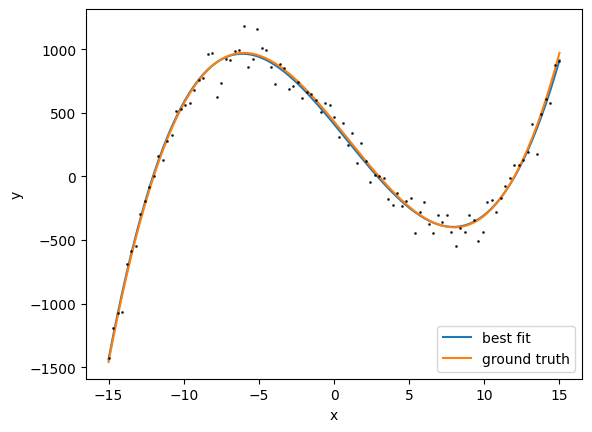

In [ ]:
def show_best_fit(state):
    fig, ax = plt.subplots(1,1)

    observed_x = state.experiment_data[["x"]].sort_values(by="x")
    observed_x = pd.DataFrame({"x": np.linspace(observed_x["x"].min(), observed_x["x"].max(), 101)})

    plt.plot(observed_x, state.model.predict(observed_x), label="best fit")

    allowed_x = pd.Series(np.linspace(*state.variables.independent_variables[0].value_range, 101), name="x")
    plt.plot(allowed_x, ground_truth(allowed_x), label="ground truth")

    state.experiment_data.plot.scatter("x", "y", s=1, alpha=0.75, c="black", ax=ax, zorder=2)

    plt.legend()

def show_coefficients(state):
    return get_equation(state.model)

show_best_fit(u)
show_coefficients(u)

We can use this pipeline to make a trivial cycle, where we keep on gathering data until we reach 1000 datapoints. Any
 condition defined on the state object could be used here, though.

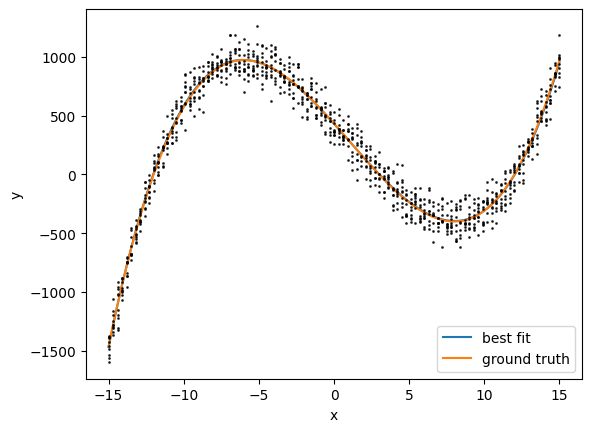

In [ ]:
v = s
while len(v.experiment_data) < 1_000:  # any condition on the state can be used here.
    v = pipeline(v)
show_best_fit(v)

### Creating Generators With State Based Functions

We can redefine the pipeline as a generator, which can be operated on using iteration tools:

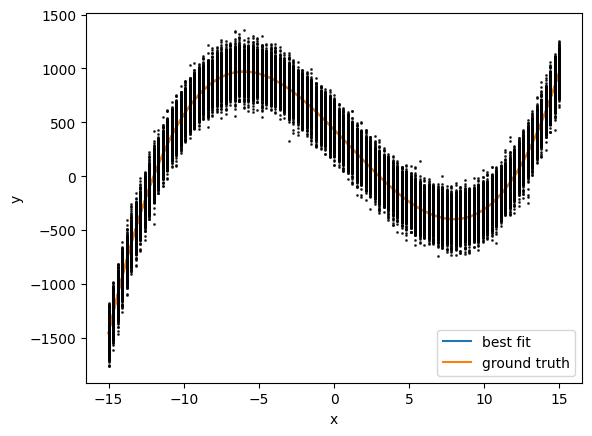

In [ ]:
def cycle(state: State) -> State:
    s_ = state
    while True:
        s_ = experiment_runner(s_)
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(s)

for i in range(1000):
    t = next(cycle_generator)
show_best_fit(t)

You can also define a cycle (or a sequence of steps) which yield the intermediate results.

In [ ]:
v0 = s
def cycle(state: State) -> State:
    s_ = state
    while True:
        print("#-- running experiment_runner --#\n")
        s_ = experiment_runner(s_)
        yield s_
        print("#-- running theorist --#\n")
        s_ = theorist(s_)
        yield s_

cycle_generator = cycle(v0)

At the outset, we have no model and an emtpy experiment_data dataframe.

In [ ]:
print(f"{v0.model=}, \n{v0.experiment_data.shape=}")

v0.model=None, 
v0.experiment_data.shape=(0, 2)


In the first `next`, we only run the "experiment_runner"

In [ ]:
v1 = next(cycle_generator)
print(f"{v1.model=}, \n{v1.experiment_data.shape=}")

#-- running experiment_runner --#

v1.model=None, 
v1.experiment_data.shape=(101, 2)


In the next step, we run the theorist on that data, but we don't add any new data:

In [ ]:
v2 = next(cycle_generator)
print(f"{v2.model=}, \n{v2.experiment_data.shape=}")

#-- running theorist --#

v2.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v2.experiment_data.shape=(101, 2)


In the next step, we run the experiment runner again and gather more observations:

In [ ]:
v3 = next(cycle_generator)
print(f"{v3.model=}, \n{v3.experiment_data.shape=}")

#-- running experiment_runner --#

v3.model=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())]), 
v3.experiment_data.shape=(202, 2)


## Adding The Experimentalist

### Single Function Experimentalists
Modifying the code to use a custom experimentalist is simple.
We define an experimentalist which adds some random observations each cycle:

In [ ]:
from autora.experimentalist.pooler.random_pooler import random_pool_executor

experimentalist = random_pool_executor

In [ ]:
experimentalist(s, num_samples=4, random_state=1)

Snapshot(variables=VariableCollection(independent_variables=[Variable(name='x', value_range=(-15, 15), allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], dependent_variables=[Variable(name='y', value_range=None, allowed_values=None, units='', type=<ValueType.REAL: 'real'>, variable_label='', rescale=1, is_covariate=False)], covariates=[]), params={}, experiment_data=Empty DataFrame
Columns: [x, y]
Index: [], conditions=           x
0   0.354649
1  13.513911
2 -10.675212
3  13.459483, model=None)

We can call the experimentalist as part of the cycle:

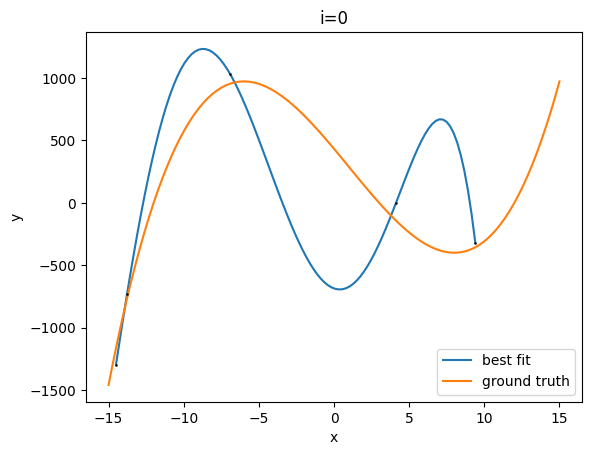

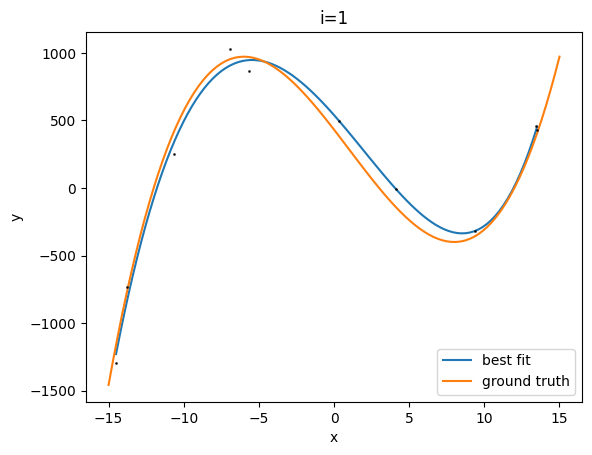

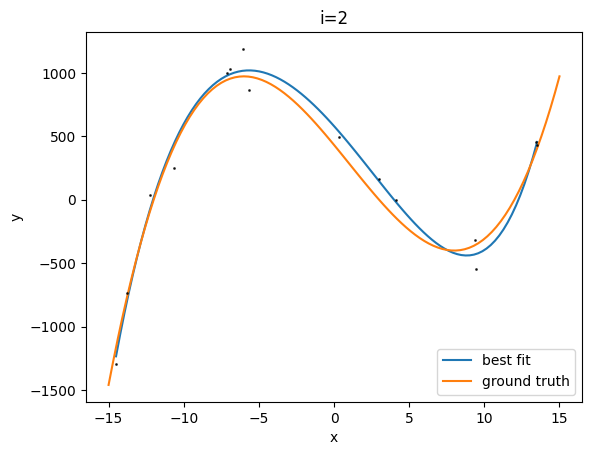

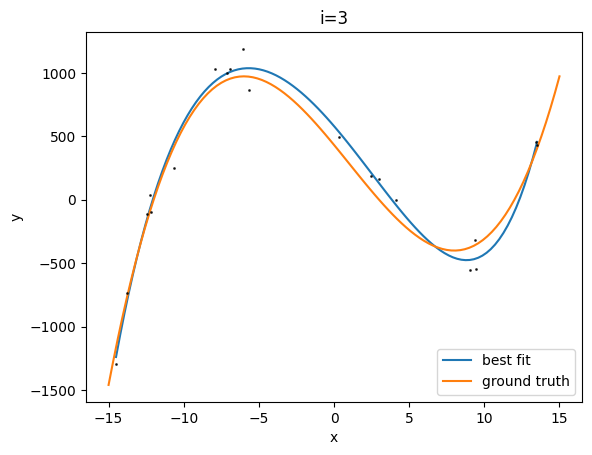

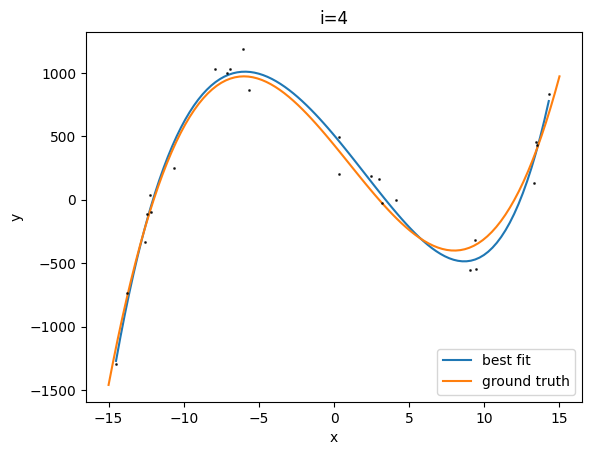

In [ ]:
u0 = s
for i in range(5):
    u0 = experimentalist(u0, num_samples=5, random_state=i)
    u0 = experiment_runner(u0)
    u0 = theorist(u0)
    show_best_fit(u0)
    plt.title(f"{i=}")
    plt.show()


### Chained Experimentalists

A more complicated experimentalist can be constructed using a pooling function and sampler(s), which are chained
together.
In this example, the `grid_pool` requires explicit specification of the allowed states, so we add those to
the `variables` attribute:

After pooler: r.conditions=         x
0   -15.00
1   -14.95
2   -14.90
3   -14.85
4   -14.80
..     ...
596  14.80
597  14.85
598  14.90
599  14.95
600  15.00

[601 rows x 1 columns]
After sampler: r.conditions=         x
446   7.30
404   5.20
509  10.45
455   7.75
201  -4.95
..     ...
439   6.95
9   -14.55
189  -5.55
373   3.65
517  10.85

[100 rows x 1 columns]


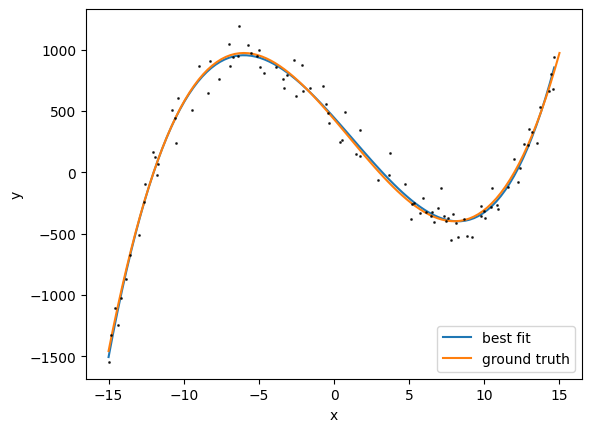

In [ ]:
from autora.experimentalist.sampler.random_sampler import random_sample_executor
from autora.experimentalist.pooler.grid import grid_pool

variables = VariableCollection(
    independent_variables=[Variable(name="x",
                                   allowed_values=np.linspace(-15, 15, 601),
                                   value_range=(-15, 15))],
    dependent_variables=[Variable("y")]
)

r = Snapshot(variables=variables)

# The experimentalist is built of two functions acting in sequence.
# The first makes a full list of all allowable conditions:
r = grid_pool(r)
print(f"After pooler: {r.conditions=}")

# The second samples ten of those allowable conditions.
r = random_sample_executor(r, num_samples=100, random_state=1)
print(f"After sampler: {r.conditions=}")

# ... then we continue with the experiment_runner and the theorist.
r = experiment_runner(r)
r = theorist(r)

show_best_fit(r)


Experimentalists could be chained together as a single line:

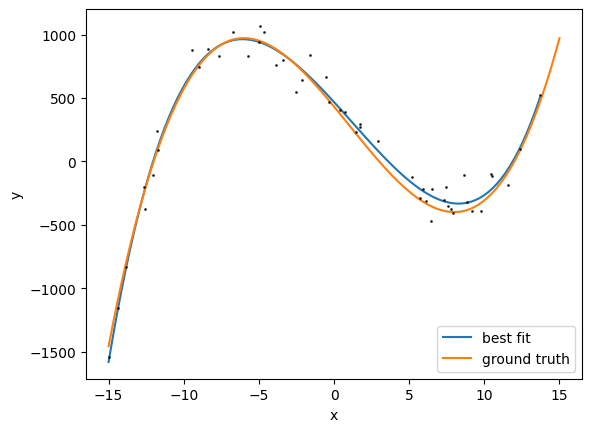

In [ ]:
r = Snapshot(variables=variables)

r = random_sample_executor(grid_pool(r), num_samples=50, random_state=1)  # experimentalist
r = experiment_runner(r)
r = theorist(r)

show_best_fit(r)

The experimentalists could also be chained together using a `def`:

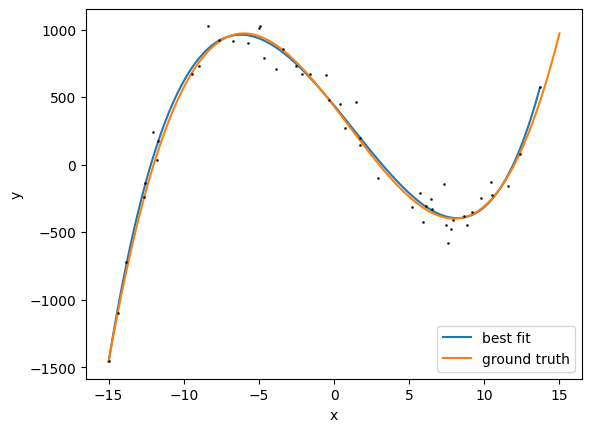

In [ ]:
def experimentalist(state):
    return random_sample_executor(grid_pool(state), num_samples=50, random_state=1)

r = Snapshot(variables=variables)

r = experimentalist(r)
r = experiment_runner(r)
r = theorist(r)

show_best_fit(r)


The experimentalists can be chained together using the `autora.experimentalist.pipeline.Pipeline`.

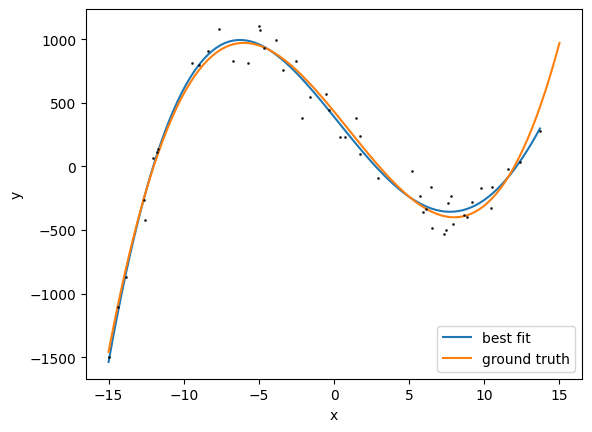

In [ ]:
# The experimentalist is built of two functions acting in sequence.
from autora.experimentalist.pipeline import Pipeline as ExperimentalistPipeline

experimentalist = ExperimentalistPipeline(
    [("pool", grid_pool),
     ("sample", random_sample_executor)],
    params={"sample": {"num_samples": 50, "random_state": 1}}
)

r = Snapshot(variables=variables)

r = experimentalist(r)
r = experiment_runner(r)
r = theorist(r)

show_best_fit(r)
